# 3-1. 들어가며

## 목차  
***
1. 단어 빈도를 이용한 벡터화  
(1) Bag of Words  
(2) Bag of Words 구현해보기  
(3) DTM과 코사인 유사도  
(4) DTM의 구현과 한계점  
(5) TF-IDF  
(6) TF-IDF 구현하기  
2. LSA와 LDA  
(1) LSA  
(2) LSA 실습  
(3) LDA  
(4) LDA 실습  
3. 텍스트 분포를 이용한 비지도 학습 토크나이저  
(1) 형태소 분석기와 단어 미등록 문제  
(2) soynlp  


# 3-2. 단어 빈도를 이용한 벡터화 (1) Bag of Words

텍스트를 숫자로 변환하는 벡터화, 그래야 컴퓨터가 알아들을 수 있으니까  
벡터화 방법으로는  
(1) 통계와 머신 러닝을 활용한 방법  
(2) 인공 신경망을 활용하는 방법  
이번에는 (1)번만 배울 예정이다. 

## Bag of Words (BoW)
단어들의 분포로 문서를 특성을 파악하는 기법  
![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-2-L-1.max-800x600.png)

이 가방은 중복을 제거하지않고 단어를 카운트한다. 즉 순서를 무시하고 빈도 정보를 정리한다.  
```
doc1 = 'John likes to watch movies. Mary likes movies too.'
BoW1 = {"John":1, "likes":2, "to":1, "watch":1, "movies":2, "Mary":1, "too":1}
```
위에서 보듯이 순서는 관련이 없이 빈도 수만 체크하고 그리고 그건 단점이 되기도  

# 3-3. 단어 빈도를 이용한 벡터화 (2) Bag of Words 구현해보기

텐서플로우 케라스와 사이킷런 라이브러리를 이용해서 가방을 만들어 보자  

## keras Tokenizer 활용

토크나이저로 가방을 만들어보자

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentence = ["John likes to watch movies. Mary likes movies too! Mary also likes to watch football games."]

def print_bow(sentence):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentence) # 단어장 생성
    bow = dict(tokenizer.word_counts) # 각 단어와 각 단어의 빈도를 bow에 저장
    print("Bag of Words :", bow) # bow 출력
    print('단어장(Vocabulary)의 크기 :', len(tokenizer.word_counts)) # 중복을 제거한 단어들의 개수

print_bow(sentence)

Bag of Words : {'john': 1, 'likes': 3, 'to': 2, 'watch': 2, 'movies': 2, 'mary': 2, 'too': 1, 'also': 1, 'football': 1, 'games': 1}
단어장(Vocabulary)의 크기 : 10


## scikit-learn CountVectorizer 활용
사이킷런 카운트벡터라이저로 가방 만들 수 있다. 

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
sentence = ["John likes to watch movies. Mary likes movies too! Mary also likes to watch football games."]
vector = CountVectorizer()
print('Bag of Words : ',vector.fit_transform(sentence).toarray()) # 코퍼스로부터 각 단어의 빈도수를 기록한다.
print('각 단어의 인덱스 :',vector.vocabulary_) # 각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.

Bag of Words :  [[1 1 1 1 3 2 2 2 1 2]]
각 단어의 인덱스 : {'john': 3, 'likes': 4, 'to': 7, 'watch': 9, 'movies': 6, 'mary': 5, 'too': 8, 'also': 0, 'football': 1, 'games': 2}


vector.fit_transform(sentence).toarray() -> 단어 없이 빈도수만 출력, 어떤 단어의 빈도수인지 알 수 없다.  
vector.vocabulary_ -> 이게 단어에 인덱스를 붙여주고 인덱스가 0부터 시작인 점이 특징이다.   
'also'의 빈도는 1, 'likes'는 3번이나 나왔다는 것을 알 수 있다.

In [3]:
print('단어장(Vocabulary)의 크기 :', len(vector.vocabulary_))

단어장(Vocabulary)의 크기 : 10


이 BoW 어디에 사용할거나면

# 3-4. 단어 빈도를 이용한 벡터화 (3) DTM과 코사인 유사도

Document-Term Matrix(DTM)은 여러 문서의 BoW를 하나의 행렬로 구현한 것  
행->Document, 열->Term  
행->Term, 열->Document 로 써서 TDM으로 부르기도 한다.  

예시를 보자  
문서 1: Intelligent applications creates intelligent business processes  
문서 2: Bots are intelligent applications  
문서 3: I do business intelligence  
![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-2-L-2.max-800x600.png)


이때 각 행을 문서 벡터(document vector), 열을 단어 벡터(word vector) 라고 할 수 있다.
여러 문서 속 단어를 함께 표현하다 보니 0을 많이 가지게 되었다. 문서가 많아지면 0은 더 많아질 것.  
무튼 이걸로 문서들을 비교하면서 유사도를 구할 수 있다.  

유사도 구하는 계산은 가장 보편적으로 코사인 유사도가 있다.
새로운 예시로 유사도까지 구해보자  
문서1 : I like dog  
문서2 : I like cat  
문서3 : I like cat I like cat  
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GN-2-L-3.png)

In [4]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

doc1 = np.array([0,1,1,1]) # 문서1 벡터
doc2 = np.array([1,0,1,1]) # 문서2 벡터
doc3 = np.array([2,0,2,2]) # 문서3 벡터

def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

[코사인 유사도(Cosine Similarity)](https://wikidocs.net/24603)  
유사도는 0 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다

In [5]:
print(cos_sim(doc1, doc2)) #문서1과 문서2의 코사인 유사도
print(cos_sim(doc1, doc3)) #문서1과 문서3의 코사인 유사도
print(cos_sim(doc2, doc3)) #문서2과 문서3의 코사인 유사도

0.6666666666666667
0.6666666666666667
1.0000000000000002


# 3-5. 단어 빈도를 이용한 벡터화 (4) DTM의 구현과 한계점

## scikit-learn CountVectorizer 활용

카운트벡터라이저를 이용해서 DTM을 만드는 방법은 BoW를 만드는 방법과 동일  

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'John likes to watch movies',
    'Mary likes movies too',
    'Mary also likes to watch football games',    
]
vector = CountVectorizer()
print(vector.fit_transform(corpus).toarray()) # 코퍼스로부터 각 단어의 빈도수를 기록.
print(vector.vocabulary_) # 각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.

[[0 0 0 1 1 0 1 1 0 1]
 [0 0 0 0 1 1 1 0 1 0]
 [1 1 1 0 1 1 0 1 0 1]]
{'john': 3, 'likes': 4, 'to': 7, 'watch': 9, 'movies': 6, 'mary': 5, 'too': 8, 'also': 0, 'football': 1, 'games': 2}


## DTM의 한계

아까 잠깐 짚었는데, 많은 문서를 함께 단어장을 만들 경우 대부분 0이 된다.  
또, 단어 빈도에만 집중하기 때문에 the와 같은 불용어가 어떤 두 문서에 자주 나왔다고 그 문서끼리 유사하다고 판단할 수도 있다.  
그렇다면 요한 단어와 중요하지 않은 단어에 가중치를 따로 선별해서 주는 방법은?

# 3-6. 단어 빈도를 이용한 벡터화 (5) TF-IDF

## TF-IDF

Term Frequency-Inverse Document Frequency : 단어 빈도-역문서 빈도  
모든 문서에서 자주 등장하는 단어(the, a,,,)는 중요도가 낮다고 판단하며, 특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단하는 것  
불용어처럼 중요도가 낮으면서 모든 문서에 등장하는 단어들이 노이즈가 되는 것을 완화  
그러나 DTM 보다 성능이 항상 뛰어나지 않기 때문에 우선 DTM을 만든 뒤에 TF-IDF 가중치를 DTM에 적용하는 방식으로 사용  
DTM은 이미 TF 행렬. 여기에 IDF값을 곱해주면 TF-IDF 완성  


##  TF-IDF 계산

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GN-2-L-4.png)

$$W_x,y=tf_x,y*log(N/df_x)$$

x는 단어 y는 문서 log항은 IDF  

이 IDF는 어떻게 구할까?  
문서가 5개가 있는데, like라는 단어가 문서 2에서 200번, 문서 3에서 300번 나왔다고 할 때, like의 DF는?  
단어의 빈도수가 아니고 다큐먼트 프리퀀시, 즉 등장한 문서 개수이기 때문에 $df_x$는 2이다.  
IDF를 지원하는 파이썬 패키지들에서 log는 자연로그($ln$)를 사용
N은 전체 다큐먼트 개수이므로 IDF는 $ln(5/2)$이다. 

문서2에서의 단어 'like'의 TF-IDF 값과 문서3에서의 단어 'like'의 TF-IDF값은 몇일까?  
문서2의 단어 'like'의 TF-IDF를 구하는 식은 $200×ln(5/2)$  
문서3은 당연히 $300×ln(5/2)$

# 3-7. 단어 빈도를 이용한 벡터화 (6) TF-IDF 구현하기

## TF-IDF 구현하기

In [7]:
from math import log
import pandas as pd

In [8]:
# 문서 준비
docs = [
  'John likes to watch movies and Mary likes movies too',
  'James likes to watch TV',
  'Mary also likes to watch football games',  
]

In [9]:
# 단어장 준비
vocab = list(set(w for doc in docs for w in doc.split()))
vocab.sort()
print('단어장의 크기 :', len(vocab))
print(vocab)

단어장의 크기 : 13
['James', 'John', 'Mary', 'TV', 'also', 'and', 'football', 'games', 'likes', 'movies', 'to', 'too', 'watch']


In [10]:
# 문서 수 저장
N = len(docs) # 총 문서의 수
N

3

TF-IDF 함수 만들기. 그런데 여기서 IDF는 앞에서 배운 식과 약간 다른 식을 사용한다. 많은 파이썬패키지에 맞춰 조금 조정된 식이다.   
여기서는 log항의 분모 $df_x$에 1을 더해준다. 특정 단어가 등장하지 않았을 때, 분모가 0이 되는 것을 방지하기 위함이다.  
또 log항에 1을 더해준다. $\frac{N}{df_x}$가 1이 되면 $log1=0$이 되는 것을 방지하기 위함이다.

In [11]:
def tf(t, d):
    return d.count(t)
 
def idf(t):
    df = 0
    for doc in docs:
        df += t in doc    
    return log(N/(df + 1)) + 1
 
def tfidf(t, d):
    return tf(t,d)* idf(t)

In [12]:
#  TF 함수를 사용하여 DTM 만들기  
result = []
for i in range(N): # 각 문서에 대해서 아래 명령을 수행
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]
        
        result[-1].append(tf(t, d))
        
tf_ = pd.DataFrame(result, columns = vocab)
tf_

,James,John,Mary,TV,also,and,football,games,likes,movies,to,too,watch
0,0,1,1,0,0,1,0,0,2,2,2,1,1
1,1,0,0,1,0,0,0,0,1,0,1,0,1
2,0,0,1,0,1,0,1,1,1,0,1,0,1


In [13]:
# IDF 구하기
result = []
for j in range(len(vocab)):
    t = vocab[j]
    result.append(idf(t))

idf_ = pd.DataFrame(result, index = vocab, columns=["IDF"])
idf_

,IDF
James,1.405465
John,1.405465
Mary,1.000000
TV,1.405465
also,1.405465
and,1.405465
football,1.405465
games,1.405465
likes,0.712318
movies,1.405465


1개의 문서에만 등장한 단어들만 높은 값을 가진다. => Term Frequency-Inverse Document Frequency 특징

In [14]:
result = []
for i in range(N):
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]
        
        result[-1].append(tfidf(t,d))

tfidf_ = pd.DataFrame(result, columns = vocab)
tfidf_

,James,John,Mary,TV,also,and,football,games,likes,movies,to,too,watch
0,0.000000,1.405465,1.0,0.000000,0.000000,1.405465,0.000000,0.000000,1.424636,2.81093,1.424636,1.405465,0.712318
1,1.405465,0.000000,0.0,1.405465,0.000000,0.000000,0.000000,0.000000,0.712318,0.00000,0.712318,0.000000,0.712318
2,0.000000,0.000000,1.0,0.000000,1.405465,0.000000,1.405465,1.405465,0.712318,0.00000,0.712318,0.000000,0.712318


## scikit-learn TFidVectorizer 활용

카운트벡터라이저처럼 TF-IDF를 자동으로 계산하여 출력하는 TfidfVectorizer를 사이킷런에서 제공합니다.  
위처럼 기본식을 약간 조정한 식을 사용한다. log항의 분모 $df_x$에 1을 더해주고 TF-IDF의 결과에 L2 Norm까지 추가적으로 수행한다.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
  'John likes to watch movies and Mary likes movies too',
  'James likes to watch TV',
  'Mary also likes to watch football games',  
]
tfidfv = TfidfVectorizer().fit(corpus)
vocab = list(set(tfidfv.vocabulary_.keys())) # 단어장을 리스트로 저장
vocab.sort() # 단어장을 알파벳 순으로 정렬

# TF-IDF 행렬에 단어장을 데이터프레임의 열로 지정하여 데이터프레임 생성
tfidf_ = pd.DataFrame(tfidfv.transform(corpus).toarray(), columns = vocab)
tfidf_

,also,and,football,games,james,john,likes,mary,movies,to,too,tv,watch
0,0.000000,0.321556,0.000000,0.000000,0.000000,0.321556,0.379832,0.244551,0.643111,0.189916,0.321556,0.000000,0.189916
1,0.000000,0.000000,0.000000,0.000000,0.572929,0.000000,0.338381,0.000000,0.000000,0.338381,0.000000,0.572929,0.338381
2,0.464997,0.000000,0.464997,0.464997,0.000000,0.000000,0.274634,0.353642,0.000000,0.274634,0.000000,0.000000,0.274634


# 3-8. LSA와 LDA (1) LSA

이때까지 배운 Bag of Words를 기반으로 한 표현 방법(DTM과 TF-IDF 행렬)은 근본적으로 단어의 의미를 벡터로 표현하지 못한다.  
단어들의 빈도가 아닌 의미와 주제를 알고 싶다면 LSA(Latent Semantic Analysis)로 알 수 있다.  

## LSA(Latent Semantic Analysis)

잠재 의미 분석으로 해석되는 LSA는 문서들 관계를 찾아내는 자연어 처리 정보 **검색** 기술이다.  
LSA를 사용하면 단어와 단어 사이, 문서와 문서 사이, 단어와 문서 사이의 의미적 유사성 점수를 찾아낼 수 있다.  

## 특잇값 분해

LSA를 이해하려면 먼저 선형대수학의 특잇값 분해(Singular Value Decompotion) 에 대해 이해해야 한다.  
그리고 또 우선 행렬의 용어를 파악해야 한다.   

[부록 : 행렬의 종류](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-19-%ED%96%89%EB%A0%AC?category=1057680)  
+ 단위 행렬 : 주대각선(trace) 성분이 모두 1이며 나머지 성분은 모두 0인 정사각행렬을 단위행렬
+ 역행렬 : n차 정사각행렬 행렬 A에 대해 어떤 행렬을 곱했을 때, 결과 행렬이 단위 행렬
***
특잇값 분해(Singular Value Decomposition) 란 m × n 크기의 임의의 사각 행렬 A를 아래의 그림에서 Full SVD와 같이 특이 벡터(singular vector)의 행렬와 특잇값(singular value)의 대각행렬로 분해하는 것이다.  
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GN-2-L-9.png)

+ [데이터 사이언스 스쿨: 특잇값 분해](https://datascienceschool.net/02%20mathematics/03.04%20%ED%8A%B9%EC%9E%87%EA%B0%92%20%EB%B6%84%ED%95%B4.html)  
+ [Singular value decomposition 의 목적](https://www.youtube.com/watch?v=vxJ1MzfvL5w)  

N×M  크기의 행렬 A를 다음과 같은 3개의 행렬의 곱으로 나타내는 것을 특이분해 or 특잇값 분해 라고 한다.  
행렬 Σ의 대각성분들을 특잇값(singular value),   
행렬 U의 열벡터들을 왼쪽 특이벡터(left singular vector),   
행렬 V의 행벡터들을 오른쪽 특이벡터(right singular vector)라고 한다.

이런 특잇값 분해 중에서 절단된 특잇값 분해(Truncated SVD)는  
특잇값 가운데 가장 큰(다시 말해, 가장 중요한) t개만 남기고 해당 특잇값에 대응되는 특이 벡터(singular vector) 들로 행렬 A를 근사(approximate)하도록 하는 것이다. 이때 t는 하이퍼파라미터이다.    

Truncated SVD를 수행하면 당연히 U행렬과 V행렬도 t열까지만 남는다. 이로 인해서 기존 행렬 A는 정확히 복구할 수 없게 된다.  
t를 크게하면 기존 행렬 A의 정보를 많이 가져갈 수 있지만, 노이즈를 제거하려면 t를 작게 잡아야 한다.  

## LSA와 Truncated SVD

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-2-L-10.max-800x600.png)  
$$A=USV^T$$

앞의 그림과 달리 여기서는 하이퍼파라미터를 t를 k로 표현했다

LSA는 DTM이나 TF-IDF 행렬 등에 Truncated SVD를 수행합니다. 이렇게 분해하여 얻은 행렬 3개  
U -> 문서들과 관련된 의미들을 표현한 행렬  
V^T -> 단어들과 관련된 의미를 표현한 행렬  
S -> 각 의미의 중요도를 표현한 행렬   

m을 문서의 수, n을 단어의 수라고 하였을 때, Truncated SVD를 통해 얻은 행렬 U_k는 m×k의 크기를 가진다. 문서 수는 줄어들지 않는다.  
반대로 $V_k^T$는 k×n의 크기를 가지는 행렬  
이 행렬의 각 열은 각 단어를 나타내는 m 차원의 단어 벡터가 됩니다-??? 왜 m차원?  
$V_k^T$서는 k의 크기를 가지게 되었으니 벡터의 차원이 저차원으로 축소된 셈  
차원을 축소하면서 잠재된 의미를 끌어내는 여러 방법은 '워드 임베딩'에서 더 배울 예정  

DTM이나 TF-IDF 행렬에 Truncated SVD를 수행하고 얻은 $V_k^T$행렬의 k열은 전체 코퍼스로부터 얻어낸 k개의 주요 주제(topic)라고 간주할 수도 있습니다.-k개의 열이라는 뜻이겠지? 

# 3-9. LSA와 LDA (2) LSA 실습

In [16]:
import pandas as pd
import numpy as np
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

NLTK 데이터셋을 다운로드하지 않은 상태라면 아래의 커맨드를 통해 다운로드해 줍니다. NLTK는 데이터셋을 다운로드해 주지 않으면 NLTK의 도구들이 제대로 동작하지 않습니다.

In [17]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/aiffel-
[nltk_data]     dj35/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aiffel-
[nltk_data]     dj35/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj35/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 데이터 다운로드 및 확인

In [18]:
# data 다운로드
import os

csv_filename = os.getenv('HOME')+'/aiffel/topic_modelling/data/abcnews-date-text.csv'

urllib.request.urlretrieve("https://raw.githubusercontent.com/franciscadias/data/master/abcnews-date-text.csv", 
                           filename=csv_filename)

('/home/aiffel-dj35/aiffel/topic_modelling/data/abcnews-date-text.csv',
 <http.client.HTTPMessage at 0x7fae8fd314d0>)

In [19]:
# df에 저장
data = pd.read_csv(csv_filename, error_bad_lines=False)
print(len(data))

1082168


In [20]:
data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [21]:
# 필요한 headline_text만 별도 저장
text = data[['headline_text']]
text.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [22]:
# 중복 확인
text.nunique() # 중복을 제외하고 유일한 시퀀스를 가지는 샘플의 개수를 출력

headline_text    1054983
dtype: int64

In [23]:
# 중복 샘플 제거
text.drop_duplicates(inplace=True) # 중복 샘플 제거
text = text.reset_index(drop=True)
print(len(text)) # 중복 제거 후 샘플 개수

1054983


/home/aiffel-dj35/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 데이터 정제 및 정규화

NLTK의 토크나이저를 이용해 전체 텍스트 데이터에 대해서 단어 토큰화를 수행하고, NLTK가 제공하는 불용어 리스트를 사용하여 불용어를 제거

In [24]:
# 시간 좀 걸린다.
# NLTK 토크나이저를 이용해서 토큰화
text['headline_text'] = text.apply(lambda row: nltk.word_tokenize(row['headline_text']), axis=1)

# 불용어 제거
stop_words = stopwords.words('english')
text['headline_text'] = text['headline_text'].apply(lambda x: [word for word in x if word not in (stop_words)])

text.head()

,headline_text
0,"[aba, decides, community, broadcasting, licence]"
1,"[act, fire, witnesses, must, aware, defamation]"
2,"[g, calls, infrastructure, protection, summit]"
3,"[air, nz, staff, aust, strike, pay, rise]"
4,"[air, nz, strike, affect, australian, travellers]"


In [25]:
# 단어 정규화. 3인칭 단수 표현 -> 1인칭 변환, 과거형 동사 -> 현재형 동사 등을 수행한다.
text['headline_text'] = text['headline_text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])

# 길이가 1 ~ 2인 단어는 제거.
text = text['headline_text'].apply(lambda x: [word for word in x if len(word) > 2])
print(text[:5])

0     [aba, decide, community, broadcast, licence]
1    [act, fire, witness, must, aware, defamation]
2       [call, infrastructure, protection, summit]
3            [air, staff, aust, strike, pay, rise]
4    [air, strike, affect, australian, travellers]
Name: headline_text, dtype: object


## 역토큰화 및 DTM 생성

DTM을 생성하는 CountVectorizer 또는 TF-IDF 행렬을 생성하는 TfidfVectorizer의 입력으로 사용하기 위해서 토큰화 과정을 역으로 되돌리는 역토큰화(detokenization) 

In [26]:
# 역토큰화 (토큰화 작업을 역으로 수행)
detokenized_doc = []
for i in range(len(text)):
    t = ' '.join(text[i])
    detokenized_doc.append(t)

train_data = detokenized_doc

In [27]:
train_data[:5]

['aba decide community broadcast licence',
 'act fire witness must aware defamation',
 'call infrastructure protection summit',
 'air staff aust strike pay rise',
 'air strike affect australian travellers']

In [28]:
# CountVectorizer를 사용하여 5000개 단어만 DTM을 생성
c_vectorizer = CountVectorizer(stop_words='english', max_features = 5000)
document_term_matrix = c_vectorizer.fit_transform(train_data)

In [29]:
# DTM 크기 : 문서의 수 × 단어 집합의 크기
print('행렬의 크기 :',document_term_matrix.shape)

행렬의 크기 : (1054983, 5000)


## scikit-learn TruncatedSVD 활용

토픽 수(k)는 10으로 진행  
$V_k^T$가 단어의수k×(단어의 수)의 크기를 가지도록 DTM에 TruncatedSVD를 수행  
참고 : [sklearn.decomposition.TruncatedSVD.fit_transform()](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD.fit_transform)  

In [30]:
from sklearn.decomposition import TruncatedSVD

n_topics = 10
lsa_model = TruncatedSVD(n_components = n_topics)
lsa_model.fit_transform(document_term_matrix)

array([[ 1.20435586e-02, -3.60396851e-03,  1.82318910e-02, ...,
         1.99252235e-03, -3.59258396e-03, -8.42601765e-03],
       [ 2.90383637e-02, -1.08451790e-02,  1.81956169e-02, ...,
         1.65831752e-03, -9.70252686e-03,  6.13298569e-03],
       [ 5.03081315e-03, -1.99017370e-03,  9.73685635e-03, ...,
        -2.38847992e-03, -7.61152027e-05, -2.26879601e-03],
       ...,
       [ 2.96841788e-02,  4.43160298e-03,  2.49225275e-02, ...,
         2.68799259e-02,  1.31290567e-02,  1.39258775e-02],
       [ 6.15027930e-02, -2.36587528e-03,  1.34467533e-01, ...,
         7.43401140e-01,  1.01391633e+00, -4.05011069e-02],
       [ 7.13884639e-02,  2.82978562e-02,  5.04014380e-04, ...,
         1.23750361e-02,  4.27241771e-02,  2.58006559e-02]])

In [31]:
print(np.shape(lsa_model.components_))

(10, 5000)


In [32]:
# 각 행을 전체 코퍼스의 k개의 주제(topic)로 판단하고 각 주제에서 n개씩 단어를 출력
terms = c_vectorizer.get_feature_names() # 단어 집합. 5,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(lsa_model.components_, terms)

Topic 1: [('police', 0.74636), ('man', 0.45352), ('charge', 0.21096), ('new', 0.1409), ('court', 0.11146)]
Topic 2: [('man', 0.69378), ('charge', 0.30088), ('court', 0.16785), ('face', 0.11375), ('murder', 0.10659)]
Topic 3: [('new', 0.837), ('plan', 0.23652), ('say', 0.18301), ('govt', 0.11154), ('council', 0.10865)]
Topic 4: [('say', 0.73821), ('plan', 0.35956), ('govt', 0.1675), ('council', 0.12765), ('fund', 0.07471)]
Topic 5: [('plan', 0.73245), ('council', 0.17341), ('govt', 0.14825), ('urge', 0.07991), ('water', 0.07656)]
Topic 6: [('govt', 0.53738), ('court', 0.2836), ('urge', 0.25478), ('fund', 0.2132), ('face', 0.18053)]
Topic 7: [('charge', 0.53735), ('court', 0.4219), ('face', 0.33006), ('plan', 0.13133), ('murder', 0.11667)]
Topic 8: [('win', 0.55144), ('court', 0.43034), ('kill', 0.19726), ('face', 0.11179), ('crash', 0.08463)]
Topic 9: [('win', 0.7035), ('charge', 0.37321), ('australia', 0.1102), ('cup', 0.08823), ('world', 0.08002)]
Topic 10: [('kill', 0.49316), ('crash

# 3-10. LSA와 LDA (3) LDA

문서 집합에서 토픽을 찾아낸 프로세스를 Topic Modelling이라고 한다. 많은 문서에서 주요 주제를 알아낼 때 중요.  
토픽 모델링의 또 다른 대표적인 알고리즘 중 하나는 잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)이다.  
LDA는 우선 문서들은 토픽들의 혼합으로 구성되어 있으며, 토픽들은 확률 분포에 기반하여 단어들을 생성한다고 가정. 그리고 데이터가 주어지면, LDA는 이 가정에 따라 단어들의 분포로부터 문서가 생성되는 과정을 역추적해 문서의 토픽을 찾아냅니다. - ??? 약간 이해가 덜 감

## LDA(Latent Dirichlet Allocation) 시뮬레이션

시뮬레이션 웹 사이트 : [LDA Topic Modeling Simulation](https://lettier.com/projects/lda-topic-modeling/)  
실행하면 두개의 행렬이 출력되는데  
첫 번째 행렬 : 단어\*토픽
두 번째 행렬 : 문서\*토픽


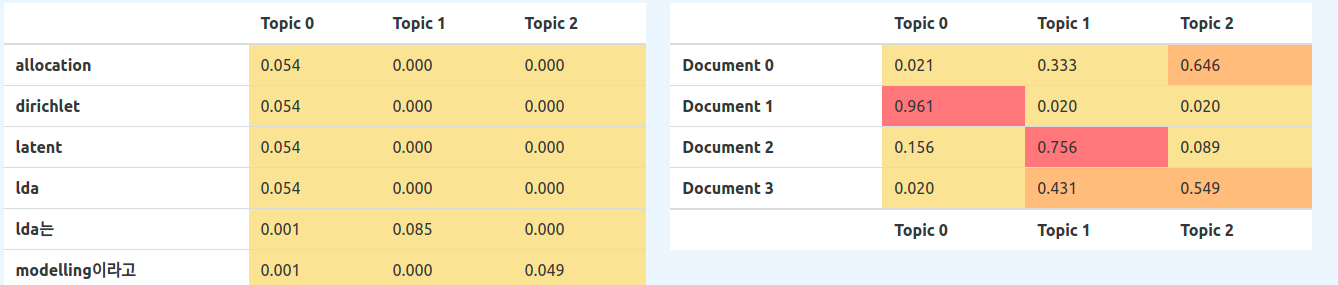

## LDA(Latent Dirichlet Allocation)의 두 가지 결과

위의 실습처럼 LDA는 각 토픽의 단어 분포, 각 문서의 토픽 분포를 추정  
LDA는 단어들의 분포로부터 해당 문서의 토픽 분포를 추정

## LDA의 가정

'나는 이 문서를 작성하기 위해서 이런 주제들을 넣을거고, 이런 주제들을 위해서는 이런 단어들을 넣을 거야.' 라는 가정하에서 토픽을 뽑아낸다.  
'단어' -> '주제' -> '문서' (단어들의 순서는 무시)  
[LDA 동영상](https://serviceapi.nmv.naver.com/flash/convertIframeTag.nhn?vid=A008B9E1EAFC02C99F92928155487839090E&outKey=V1210ad4156cf64ce0c6a3e18cecaae499f6528784c999ca6541c3e18cecaae499f65&width=544&height=306) 시청  

[위키독스: 잠재 디리클레 할당](https://wikidocs.net/30708)  
>LDA는 토픽의 제목을 정해주지 않지만, 알고리즘의 사용자는 위 결과로부터 두 토픽을 추측해낼 수 있다.  

## LSA vs. LDA
LSA는 DTM을 차원 축소하여 축소 차원에서 근접 단어들을 토픽으로 묶는 반면에, LDA는 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합 확률로 추정하여 토픽을 추출합니다.

# 3-11. LSA와 LDA (4) LDA 실습

역토큰화 과정을 거친 데이터 사용

## TF-IDF 행렬 생성

LDA는 DTM 또는 TF-IDF를 입력으로 받을 수 있다. 여기서는 TF-IDF 사용 예정

In [33]:
# 상위 5,000개의 단어만 사용
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features= 5000)
tf_idf_matrix = tfidf_vectorizer.fit_transform(train_data)

# TF-IDF 행렬의 크기를 확인해봅시다.
print('행렬의 크기 :',tf_idf_matrix.shape)

행렬의 크기 : (1054983, 5000)


## scikit-learn LDA Model 활용

토픽의 개수는 10개로 정했습니다. 이는 n_components의 인자값

In [34]:
# 시간 좀 걸린다.
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=777, max_iter=1)
lda_model.fit_transform(tf_idf_matrix)

array([[0.0335099 , 0.0335099 , 0.0335099 , ..., 0.17024867, 0.0335099 ,
        0.0335099 ],
       [0.03365631, 0.03365631, 0.03365631, ..., 0.03365631, 0.03365631,
        0.03365631],
       [0.25184095, 0.0366096 , 0.0366096 , ..., 0.0366096 , 0.0366096 ,
        0.0366096 ],
       ...,
       [0.26687206, 0.02914502, 0.02914502, ..., 0.13007484, 0.02916018,
        0.28739608],
       [0.10378115, 0.02637829, 0.12325014, ..., 0.02637829, 0.02637829,
        0.02637829],
       [0.03376055, 0.03376055, 0.2255442 , ..., 0.03376055, 0.03376055,
        0.03376055]])

In [35]:
# 행렬 크기 확인
print(np.shape(lda_model.components_))

(10, 5000)


In [36]:
# # LDA의 결과 토픽과 각 단어의 비중을 출력합시다.
# # lsa 베낀거
# # from sklearn.decomposition import TruncatedSVD

# n_topics = 10
# lda_model = TruncatedSVD(n_components = n_topics)
# lda_model.fit_transform(document_term_matrix)

In [37]:
# LDA의 결과 토픽과 각 단어의 비중을 출력합시다
terms = tfidf_vectorizer.get_feature_names() # 단어 집합. 5,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])

get_topics(lda_model.components_, terms)

Topic 1: [('australia', 9359.06334), ('sydney', 5854.97288), ('attack', 4784.76322), ('change', 4193.63035), ('year', 3924.88997)]
Topic 2: [('government', 6344.07413), ('charge', 5947.12292), ('man', 4519.7974), ('state', 3658.16422), ('live', 3625.10473)]
Topic 3: [('australian', 7666.65651), ('say', 7561.01807), ('police', 5513.22932), ('home', 4048.38409), ('report', 3796.04446)]
Topic 4: [('melbourne', 5298.35047), ('south', 4844.59835), ('death', 4281.78433), ('china', 3214.44581), ('women', 3029.28443)]
Topic 5: [('win', 5704.0914), ('canberra', 4322.0963), ('die', 4025.63057), ('open', 3771.65243), ('warn', 3577.47151)]
Topic 6: [('court', 5246.3124), ('world', 4536.86331), ('country', 4166.34794), ('woman', 3983.97748), ('crash', 3793.50267)]
Topic 7: [('election', 5418.5038), ('adelaide', 4864.95604), ('house', 4478.6135), ('school', 3966.82676), ('2016', 3955.11155)]
Topic 8: [('trump', 8189.58575), ('new', 6625.2724), ('north', 3705.40987), ('rural', 3521.42659), ('donald',

# 3-12. 텍스트 분포를 이용한 비지도 학습 토크나이저 (1) 형태소 분석기와 단어 미등록 문제


지금까지는 띄어쓰기 단위의 단어 분포를 이용  
이번에는 텍스트의 분포를 이용 -> 비지도 학습 토크나이저 알아보자  

## 형태소 분석기의 필요성

한국어는 하나의 어절이 어간 + 접사 로 이루어져 있는 교착어이다. 조사라는 품사는 이 교착어에만 있는거다.  
그래서 영어처럼 띄어쓰기 단위 토큰화가 제대로 동작하지 않는다.  

In [38]:
kor_text = "사과의 놀라운 효능이라는 글을 봤어. 그래서 오늘 사과를 먹으려고 했는데 사과가 썩어서 슈퍼에 가서 사과랑 오렌지 사 왔어"
print(kor_text.split())

['사과의', '놀라운', '효능이라는', '글을', '봤어.', '그래서', '오늘', '사과를', '먹으려고', '했는데', '사과가', '썩어서', '슈퍼에', '가서', '사과랑', '오렌지', '사', '왔어']


위의 예시를 보면 '사과'라는 단어가 4번이 나왔는데, 띄어쓰기를 기준으로 하면 붙어있는 조사때문에 각각 다른 단어로 인식하는 문제가 있다. 이를 해결하기 위해 한국어는 '형태소 분석기'를 사용한다.

In [39]:
# 형태소 분석기 Okt 사용
from konlpy.tag import Okt
tokenizer = Okt()
print(tokenizer.morphs(kor_text))

['사과', '의', '놀라운', '효능', '이라는', '글', '을', '봤어', '.', '그래서', '오늘', '사과', '를', '먹으려고', '했는데', '사과', '가', '썩어서', '슈퍼', '에', '가서', '사과', '랑', '오렌지', '사', '왔어']


## 미등록 단어 문제

예를 들어 '모두의연구소'를 하나의 단어로 인식하고 싶은데 Okt는 그렇지 못한다.  
그렇다면 어떤 문자 시퀀스가 함께 자주 등장하는 빈도수가 높을 때, 해당 문자 시퀀스를 형태소로 인식하는 분석기가 고안되었고 그것이 바로 soynlp이다.  

# 3-13. 텍스트 분포를 이용한 비지도 학습 토크나이저 (2) soynlp

soynlp는 품사 태깅, 형태소 분석 등을 지원하는 한국어 형태소 분석기   
비지도 학습으로 형태소를 분석하고 위에서 말한 것과 같이 자주 등장하는 단어들의 시퀀스를 형태소로 분석한다.  
(soynlp 형태소 분석기는 내부적으로 단어 점수표로 동작한다. 이 점수는 응집 확률(cohesion probability) 과 브랜칭 엔트로피(branching entropy) 를 활용)  

## soynlp 실습

설치 먼저
```
$ pip install soynlp
```


In [40]:
# soynlp 깃허브에서 제공하는 예제 말뭉치를 다운로드
import urllib.request

txt_filename = os.getenv('HOME')+'/aiffel/topic_modelling/data/2016-10-20.txt'

urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt",\
                            filename=txt_filename)

('/home/aiffel-dj35/aiffel/topic_modelling/data/2016-10-20.txt',
 <http.client.HTTPMessage at 0x7fae830af510>)

In [41]:
# 말 뭉치 -> 문서 단위로 분리
from soynlp import DoublespaceLineCorpus

# 말뭉치에 대해서 다수의 문서로 분리
corpus = DoublespaceLineCorpus(txt_filename)
len(corpus)

30091

In [42]:
# 몇 개만 출력
i = 0
for document in corpus:
  if len(document) > 0:
    print(document)
    i = i+1
  if i == 3:
    break

19  1990  52 1 22
오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다 독자제공 영상 캡처 연합뉴스  서울 연합뉴스 김은경 기자 사제 총기로 경찰을 살해한 범인 성모 46 씨는 주도면밀했다  경찰에 따르면 성씨는 19일 오후 강북경찰서 인근 부동산 업소 밖에서 부동산업자 이모 67 씨가 나오기를 기다렸다 이씨와는 평소에도 말다툼을 자주 한 것으로 알려졌다  이씨가 나와 걷기 시작하자 성씨는 따라가면서 미리 준비해온 사제 총기를 이씨에게 발사했다 총알이 빗나가면서 이씨는 도망갔다 그 빗나간 총알은 지나가던 행인 71 씨의 배를 스쳤다  성씨는 강북서 인근 치킨집까지 이씨 뒤를 쫓으며 실랑이하다 쓰러뜨린 후 총기와 함께 가져온 망치로 이씨 머리를 때렸다  이 과정에서 오후 6시 20분께 강북구 번동 길 위에서 사람들이 싸우고 있다 총소리가 났다 는 등의 신고가 여러건 들어왔다  5분 후에 성씨의 전자발찌가 훼손됐다는 신고가 보호관찰소 시스템을 통해 들어왔다 성범죄자로 전자발찌를 차고 있던 성씨는 부엌칼로 직접 자신의 발찌를 끊었다  용의자 소지 사제총기 2정 서울 연합뉴스 임헌정 기자 서울 시내에서 폭행 용의자가 현장 조사를 벌이던 경찰관에게 사제총기를 발사해 경찰관이 숨졌다 19일 오후 6시28분 강북구 번동에서 둔기로 맞았다 는 폭행 피해 신고가 접수돼 현장에서 조사하던 강북경찰서 번동파출소 소속 김모 54 경위가 폭행 용의자 성모 45 씨가 쏜 사제총기에 맞고 쓰러진 뒤 병원에 옮겨졌으나 숨졌다 사진은 용의자가 소지한 사제총기  신고를 받고 번동파출소에서 김창호 54 경위 등 경찰들이 오후 6시 29분께 현장으로 출동했다 성씨는 그사이 부동산 앞에 놓아뒀던 가방을 챙겨 오패산 쪽으로 도망간 후였다  김 경위는 오패산 터널 입구 오른쪽의 급경사에서 성씨에

기존 형태소 분석기와 다르게 soynlp는 학습 과정을 거쳐야 한다.  
이는 전체 코퍼스로부터 응집 확률과 브랜칭 엔트로피 단어 점수표를 만드는 과정
WordExtractor.extract()를 통해서 전체 코퍼스에 대해 단어 점수표를 계산한다.  


In [43]:
from soynlp.word import WordExtractor
word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score_table = word_extractor.extract()

training was done. used memory 2.638 Gb
all cohesion probabilities was computed. # words = 223348
all branching entropies was computed # words = 361598
all accessor variety was computed # words = 361598


## soynlp의 응집 확률(cohesion probability)

응집 확률은 내부 문자열(substring)이 얼마나 응집하여 자주 등장하는지를 판단하는 척도  
문자열을 문자 단위로 분리하여 내부 문자열을 만드는 과정에서 왼쪽부터 순서대로 문자를 추가하면서 각 문자열이 주어졌을 때 그다음 문자가 나올 확률을 계산하여 누적곱을 한 값

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GN-2-L-14.png)

위의 수식을 아래의 예제로 이해해보자.  
'반포한강공원에'라는 7의 길이를 가진 문자 시퀀스에 대해서 각 내부 문자열의 스코어  
![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-2-L-15.max-800x600.png)

In [44]:
word_score_table["반포한"].cohesion_forward

0.08838002913645132

In [45]:
word_score_table["반포한강"].cohesion_forward

0.19841268168224552

In [46]:
word_score_table["반포한강공"].cohesion_forward

0.2972877884078849

In [47]:
word_score_table["반포한강공원"].cohesion_forward

0.37891487632839754

In [48]:
word_score_table["반포한강공원에"].cohesion_forward

0.33492963377557666

응집 확률이 최대화가 되는 내부 문자열 구간은 '반포한강공원'입니다. 다시 말해 '반포한강공원'이 하나의 단어일 확률이 높습니다.

## soynlp의 브랜칭 엔트로피(branching entropy)

브랜칭 엔트로피(Branching Entropy) 는 확률 분포의 엔트로피값을 사용해서 주어진 문자열 다음 문자의 등장 가능성을 판단하는 척도

In [49]:
word_score_table["디스"].right_branching_entropy

1.6371694761537934

In [50]:
word_score_table["디스플"].right_branching_entropy

-0.0

In [51]:
word_score_table["디스플레"].right_branching_entropy

-0.0

In [52]:
word_score_table["디스플레이"].right_branching_entropy

3.1400392861792916

하나의 단어가 끝나면 그 경계 부분부터 다시 브랜칭 엔트로피값이 증가한다. -> 이 값으로 단어 판단 가능  

이렇게 응집 확률과 브랜칭 엔트로피 값 구해봤는데, 이 두가지 점수를 사용해서 토큰화를 해보자

## soynlp의 (1) LTokenizer

띄어쓰기 단위로 잘 나뉜 문장은 L 토크나이저(LTokenizer)를 사용하면 좋습니다.

한국어는 띄어쓰기 단위로 나눈 어절 토큰은 주로 L 토큰 + R 토큰의 형식을 가질 때가 많습니다. 예를 들어서 '공원에'는 '공원 + 에'로 나눌 수 있겠지요. 또는 '공부하는'은 '공부 + 하는'으로 나눌 수도 있을 것입니다. L 토크나이저는 L 토큰 + R 토큰으로 나누되, 분리 기준으로 점수가 가장 높은 L 토큰을 찾아내는 원리를 가지고 있습니다.

In [53]:
from soynlp.tokenizer import LTokenizer

scores = {word:score.cohesion_forward for word, score in word_score_table.items()}
l_tokenizer = LTokenizer(scores=scores)
l_tokenizer.tokenize("국제사회와 우리의 노력들로 범죄를 척결하자", flatten=False)

[('국제사회', '와'), ('우리', '의'), ('노력', '들로'), ('범죄', '를'), ('척결', '하자')]

## (2) 최대 점수 토크나이저

최대 점수 토크나이저(MaxScoreTokenizer)는 띄어쓰기가 되어 있지 않은 문장에서 점수가 높은 글자 시퀀스를 순차적으로 찾아내는 토크나이저입니다. 띄어쓰기가 되어 있지 않은 문장을 넣어서 점수를 통해 토큰화된 결과를 보겠습니다.

In [54]:
from soynlp.tokenizer import MaxScoreTokenizer

maxscore_tokenizer = MaxScoreTokenizer(scores=scores)
maxscore_tokenizer.tokenize("국제사회와우리의노력들로범죄를척결하자")

['국제사회', '와', '우리', '의', '노력', '들로', '범죄', '를', '척결', '하자']

진짜 양 많다.하하하핳